In [1]:
import math
import itertools
from ipywidgets import interact, IntSlider
import numpy as np
import scipy
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
def load_image(file_path: str) -> np.ndarray:
    pil_image = Image.open(file_path)
    return np.array(pil_image)

In [3]:
def to_grayscale(img: np.ndarray) -> np.ndarray:
    return np.array(Image.fromarray(img).convert('L'), dtype=float)

# Load Image

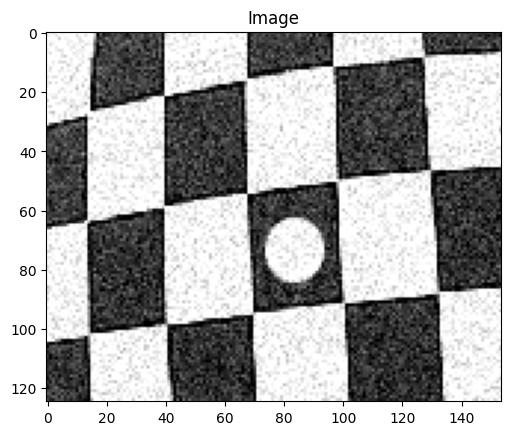

In [4]:
path = 'images/karo.png'

# Load Image into memory
image = load_image(path)
    
# Convert Grayscale values to Float
image = image.astype(float)

plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

# Compute Gradients

In [5]:
gradientX = np.array([[-1, 0, 1],
                      [-2, 0, 2],
                      [-1, 0, 1]])
gradientY = np.array([[-1, -2, -1],
                      [0,  0,  0],
                      [1,  2,  1]])

In [6]:
window_size = 7

Ix = scipy.ndimage.correlate(image, gradientX)
Iy = scipy.ndimage.correlate(image, gradientY)
I = np.sqrt(Ix**2 + Iy**2)

n = np.ones((window_size, window_size))

Axx = scipy.ndimage.correlate(Ix**2, n)
Axy = scipy.ndimage.correlate(Ix*Iy, n)
Ayy = scipy.ndimage.correlate(Iy**2, n)

b = -Axx - Ayy
c = Axx*Ayy-Axy**2
D = b**2-4*c

eigenvalue_l1 = (-b + np.sqrt(D))/2
eigenvalue_l2 = (-b-np.sqrt(D))/2

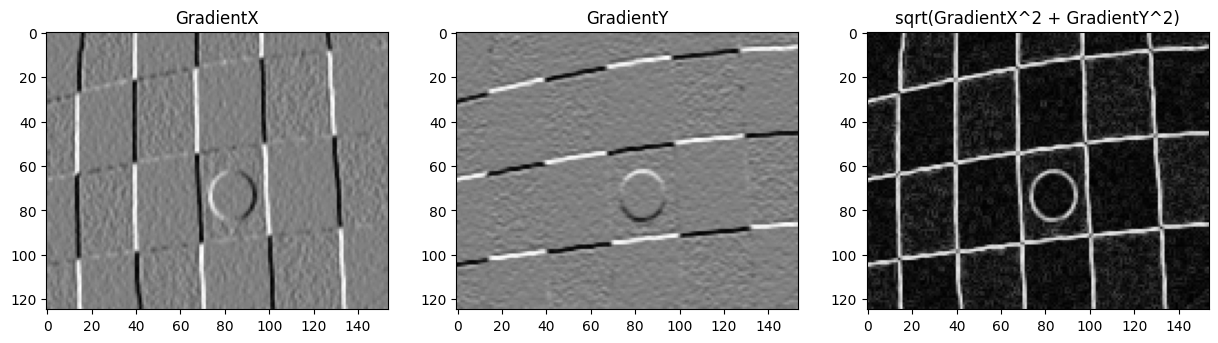

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(Ix, cmap='gray')
ax1.set_title('GradientX')

ax2.imshow(Iy, cmap='gray')
ax2.set_title('GradientY')

ax3.imshow(I, cmap='gray')
ax3.set_title('sqrt(GradientX^2 + GradientY^2)')

plt.show()

# Interactive Gradient-PCA-Analysis

In [8]:
def calculate_window_start_and_end(x_pos, y_pos, window_size):
    if window_size % 2 == 0:
        raise Exception('Window Size has to be an odd number')
    
    start_y = max(0, y_pos - (window_size - 1) // 2)
    end_y = min(image.shape[0], y_pos + (window_size - 1) // 2 + 1)
    start_x = max(0, x_pos - (window_size - 1) // 2)
    end_x = min(image.shape[1], x_pos + (window_size - 1) // 2 + 1)

    return start_x, end_x, start_y, end_y

In [18]:
def update_plots(pos_x, pos_y):
    start_x, end_x, start_y, end_y = calculate_window_start_and_end(pos_x, pos_y, window_size)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
    
    # Plot Image with Rectangle
    ax1.imshow(image, cmap='gray')
    rect = Rectangle((start_x, start_y), window_size, window_size, linewidth=2, edgecolor='r', facecolor='none')
    ax1.add_patch(rect)
    ax1.set_title('Image')

    # Plot zoomed Image
    ax2.imshow(image[start_y:end_y, start_x:end_x], cmap='gray')
    ax2.set_title('Image-Zoom')

    # Plot Gradient including the Vectors
    ax3.imshow(I[start_y:end_y, start_x:end_x], cmap='gray')
    ax3.set_title('Gradient-Zoom')
    for y, x in itertools.product(range(start_y, end_y), range(start_x, end_x)):
        start_point = (y - start_y, x - start_x)
        
        Ix_value = Ix[y, x]
        Iy_value = Iy[y, x]
    
        vector = (Iy_value, Ix_value)
        
        # Calculate the end point of the arrow
        end_point = (start_point[0] + 1/500 * vector[0], start_point[1] + 1/500 * vector[1])
        # Draw the arrow
        ax3.arrow(start_point[1], start_point[0], end_point[1] - start_point[1], end_point[0] - start_point[0], color='red', head_width=0.2, head_length=0.2)

    # Plot Scatter Plot
    eigenvector_l1 = np.array([Axy[pos_y, pos_x], eigenvalue_l1[pos_y, pos_x] - Axx[pos_y, pos_x]])
    eigenvector_l2 = np.array([Axy[pos_y, pos_x], eigenvalue_l2[pos_y, pos_x] - Axx[pos_y, pos_x]])
    
    # Normalize eigenvectors
    eigenvector_l1 /= np.linalg.norm(eigenvector_l1)
    eigenvector_l2 /= np.linalg.norm(eigenvector_l2)

    scatter_x, scatter_y = [], []
    for y, x in itertools.product(range(start_y, end_y), range(start_x, end_x)):
        scatter_x.append(Ix[y, x])
        scatter_y.append(Iy[y, x])
    
    ax4.scatter(scatter_x, scatter_y, alpha=0.3)
    ax4.set_xlim(-1100, 1100)
    ax4.set_ylim(-1100, 1100)
    ax4.grid(True)
    ax4.set_title('PCA-Scatter-Plot')
    ax4.axhline(0, color='black', linewidth=1)
    ax4.axvline(0, color='black', linewidth=1)
    ax4.arrow(0, 0, eigenvector_l1[0] * eigenvalue_l1[pos_y, pos_x] * 0.0001, eigenvector_l1[1] * eigenvalue_l1[pos_y, pos_x] * 0.0001, 
              head_width=30, head_length=30, color='r', label='Eigenvector for l1')
    ax4.arrow(0, 0, eigenvector_l2[0] * eigenvalue_l2[pos_y, pos_x] * 0.0001, eigenvector_l2[1] * eigenvalue_l2[pos_y, pos_x] * 0.0001, 
              head_width=30, head_length=30, color='orange', label='Eigenvector for l2')

    plt.show()
    
x_pos_slider = IntSlider(value=window_size//2, min=window_size//2, max=image.shape[1]-window_size//2, step=1, description='X')
y_pos_slider = IntSlider(value=window_size//2, min=window_size//2, max=image.shape[0]-window_size//2, step=1, description='Y')

interact(update_plots, pos_x=x_pos_slider, pos_y=y_pos_slider)

interactive(children=(IntSlider(value=3, description='X', max=151, min=3), IntSlider(value=3, description='Y',…

<function __main__.update_plots(pos_x, pos_y)>

# Plot Lambda-2 Eigenvalue

### Lambda-2 Wert bereits sehr aussagekräftig. Lambda-1 muss gar nicht miteinbezogen werden

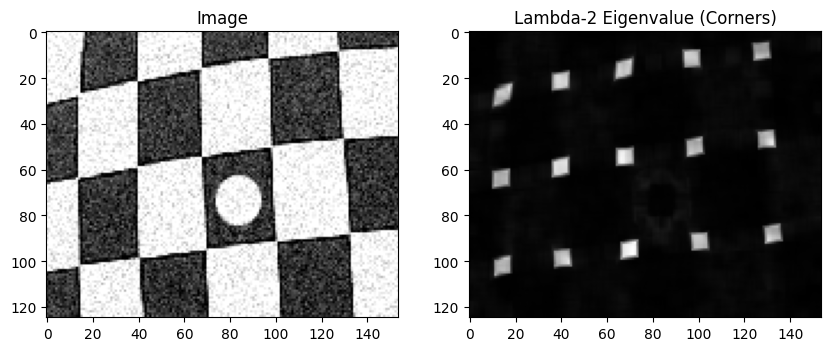

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(image, cmap='gray')
ax1.set_title('Image')

ax2.imshow(eigenvalue_l2, cmap='gray')
ax2.set_title('Lambda-2 Eigenvalue (Corners)')

plt.show()